In [1]:
import sys
sys.path.append("/home/federico/programming/CM/")
# sys.path.append("/home/federico/Desktop/University/CM/")


from Network import NR, NC
import src.utils as utils
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from matplotlib import pyplot as plt

In [2]:
def plot_stats(conf, dataset, test, X_train, y_train, X_test, y_test, save=False):
    print(conf[dataset][test])
    
    if dataset == 'cup':
        net = NR(**conf[dataset][test])
    else:
        net = NC(**conf[dataset][test])

    net.fit(X_train, y_train, test_data=(X_test, y_test))
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, time=True)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save)
    net.plot_results(f"{dataset}_{test}_score", score=True, save=save, time=True)

    net.plot_grad(f"{dataset}_{test}", save=save)
    print(net.best_score())

In [3]:
def report_plots(dataset, net_SGD, net_SGD_nest, net_SGM, score=False):
    
    sgd_loss = net_SGD.train_loss
    sgd_nest_loss = net_SGD_nest.train_loss
    sgm_loss = net_SGM.train_loss

    # Conditional configuration
    x_label_time = 'Execution Time'
    x_label_ep = 'Epochs'

    train_res_SGD = net_SGD.train_scores if score else net_SGD.train_loss
    train_res_SGD_nest = net_SGD_nest.train_scores if score else net_SGD_nest.train_loss
    train_res_SGM = net_SGM.train_scores if score else net_SGM.train_loss
    x_SGD_time = net_SGD.epochs_time
    x_SGD_ep = list(range(len(train_res_SGD)))
    x_SGD_nest_time = net_SGD_nest.epochs_time
    x_SGD_nest_ep = list(range(len(train_res_SGD_nest)))
    x_SGM_time = net_SGM.epochs_time
    x_SGM_ep = list(range(len(train_res_SGM)))
    
    
    print("----- SGD -----")
    print(params[dataset]['SGD'])
    print(net_SGD.best_score(),"\n")
    
    print("----- SGD nesterov-----")
    print(params[dataset]['SGD'])
    print(net_SGD_nest.best_score(),"\n")

    print("----- SGM -----")
    print(params[dataset]['SGM'])
    print(net_SGM.best_score(),"\n")

    def plot_internal(x_datas, y_datas, x_label, y_label, title):
        plt.semilogy(x_datas[0], y_datas[0], '--', label='SGD CM')
        plt.semilogy(x_datas[1], y_datas[1], '--', label='SGD NAG')
        plt.semilogy(x_datas[2], y_datas[2], '--', label='SGM')
        plt.xlabel(x_label)
        plt.ylabel (y_label)
        plt.legend(loc='best')
        plt.title (title)
        plt.show()
        plt.clf()

    plot_internal([x_SGD_time, x_SGD_nest_time, x_SGM_time], 
                  [train_res_SGD, train_res_SGD_nest, train_res_SGM],
                  x_label_time, 
                  'Loss', 
                  f'Loss NN {dataset} dataset'
                 )
    
    plot_internal([x_SGD_ep, x_SGD_nest_ep, x_SGM_ep], 
                  [train_res_SGD, train_res_SGD_nest, train_res_SGM],
                  x_label_time, 
                  'Loss', 
                  f'Loss NN {dataset} dataset'
                 )
    
    plot_internal([x_SGD_ep, x_SGD_nest_ep, x_SGM_ep], 
                  [net_SGD.grad_est_per_epoch, net_SGD_nest.grad_est_per_epoch, net_SGM.grad_est_per_epoch],
                  x_label_time, 
                  'Loss', 
                  f'Gradient norms for both SGD and SGM over {dataset}'
                 )
        
#     # Plots losses w.r.t. time
#     plt.semilogy(x_SGD_time, train_res_SGD, '--', label='SGD CM')
#     plt.semilogy(x_SGD_nest_time, train_res_SGD_nest, '--', label='SGD NAG')
#     plt.semilogy(x_SGM_time, train_res_SGM, '--', label='SGM')
#     plt.xlabel(x_label_time)
#     plt.ylabel ('Loss')
#     plt.legend(loc='best')
#     plt.title (f'Loss NN {dataset} dataset')
#     plt.show()
#     plt.clf()

#     # Plots losses w.r.t. epochs
#     plt.semilogy(x_SGD_ep, train_res_SGD, '--', label='SGD CM')
#     plt.semilogy(x_SGD_nest_ep, train_res_SGD_nest, '--', label='SGD NAG')
#     plt.semilogy(x_SGM_ep, train_res_SGM, '--', label='Loss SGM')
#     plt.xlabel(x_label_ep)
#     plt.ylabel ('Loss')
#     plt.legend(loc='best')
#     plt.title (f'Loss NN {dataset} dataset')
#     plt.show()
#     plt.clf()

#     # Plots gradient norms
#     plt.semilogy(x_SGD_ep, net_SGD.grad_est_per_epoch, '--', label='SGD CM')
#     plt.semilogy(x_SGD_nest_ep, net_SGD_nest.grad_est_per_epoch, '--', label='SGD NAG')
#     plt.semilogy(x_SGM_ep, net_SGM.grad_est_per_epoch, '--', label='SGM')
#     plt.xlabel(x_label_ep)
#     plt.ylabel ('Gradient Norm')
#     plt.legend(loc='best')
#     plt.title (f'Gradient norms for both SGD and SGM over {dataset}')
#     plt.show()
#     plt.clf()

In [4]:
def report_stats(dataset, score=False, debug=False):
    if dataset == 'cup':
        nn = NR
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
    else:
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC

    # Plots together results from SGD and SGM
    param_SGD = params[dataset]['SGD'].copy()
    param_SGD_nest = params[dataset]['SGD'].copy()
    param_SGM = params[dataset]['SGM'].copy()
    
    param_SGD['debug'] = debug
    net_SGD = nn(**param_SGD)

    param_SGD_nest['debug'] = debug
    param_SGD_nest['nesterov'] = True
    net_SGD_nest = nn(**param_SGD_nest)

    param_SGM['debug'] = debug
    net_SGM = nn(**param_SGM)    

    net_SGD.fit(X_train, y_train)
    net_SGD_nest.fit(X_train, y_train)
    net_SGM.fit(X_train, y_train)

    return net_SGD, net_SGD_nest, net_SGM

In [5]:
datasets = {
    'cup': '../../data/ML-CUP20-TR.csv',
    'monk1': '../../data/monks-1',
    'monk2': '../../data/monks-2', 
    'monk3': '../../data/monks-3', 
}


# TODO: aggiungere json di configurazione
params = {
    'cup': {
        'SGD': {
            'batch_size': 32,
            'epochs': 1000,
            'eps': 1e-6,
            'eta': 0.001,
            'lmbda': 0.001,
            'momentum': 0.,
            'optimizer': "SGD",
            'sizes': [30, 50],
            'debug': True,
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 1000,
            'eps':1e-6,
            'eta': 0.01,
            'lmbda': 0.,
            'optimizer': "SGM",
            'sizes': [50, 50],
            'debug': True,
        }
    },
    'monk1': {
        'SGD': {
            'batch_size': 32,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.1,
            'lmbda': 0.01,
            'momentum': 0.9,
            'nesterov': True,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.3,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True
        }
    },
    'monk2': {
        'SGD': {
            'batch_size': None,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.7,
            'lmbda': 0.01,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': None,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.7,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True,
        }
    },
    'monk3': {
        'SGD': {
            'batch_size': 32,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.5,
            'lmbda': 0.01,
            'momentum': 0.,
            'nesterov': True,
            'optimizer': "SGD",
            'sizes': [2],
            'debug': True
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.7,
            'lmbda': 0.0001,
            'optimizer': "SGM",
            'sizes': [3],
            'debug': True,
        }
    }
}

## Testing configuration

In [6]:
def plot_net(net, dataset, test):
    net.plot_results(f"{dataset}_{test}", score=False, time=True, log=True)
    net.plot_results(f"{dataset}_{test}", score=False, time=False, log=True)
    net.plot_results(f"{dataset}_{test}", score=True, time=True)
    net.plot_results(f"{dataset}_{test}", score=True, time=False)
    net.plot_grad(f"{dataset}_{test}", time=True)

    print(net.best_score(name=f"{dataset}_{test}", save=False))

### Monk1

In [8]:
dataset = 'monk1'

monk1 = {
    'SGD': {
        'batch_size': 32,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.1,
        'lmbda': 0.01,
        'momentum': 0.9,
        'nesterov': False,
        'optimizer': "SGD",
        'sizes': [5],
        'debug': True
    },
    'SGD_nest': {
        'batch_size': 32,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.1,
        'lmbda': 0.01,
        'momentum': 0.9,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [5],
        'debug': True
    },
    'SGM': {
        'batch_size': 32,
        'epochs': 2000,
        'eps':1e-6,
        'eta': 0.3,
        'lmbda': 0.01,
        'optimizer': "SGM",
        'sizes': [5],
        'debug': True
    }
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk1'])
nn = NC
    
net_SGD = nn(**monk1['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk1['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGM = nn(**monk1['SGM'])
net_SGM.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 8.65166e-02 || Loss: 1.35193e-01, 1.35097e-01 || Score: 0.528, 0.532
2       || Gradient norm: 6.84247e-02 || Loss: 1.27500e-01, 1.24141e-01 || Score: 0.544, 0.548
3       || Gradient norm: 7.39229e-02 || Loss: 1.23031e-01, 1.16896e-01 || Score: 0.551, 0.589
4       || Gradient norm: 7.01225e-02 || Loss: 1.19648e-01, 1.11473e-01 || Score: 0.593, 0.629
5       || Gradient norm: 7.10665e-02 || Loss: 1.16141e-01, 1.06104e-01 || Score: 0.623, 0.694
6       || Gradient norm: 3.91868e-02 || Loss: 1.12157e-01, 1.00482e-01 || Score: 0.648, 0.75 
7       || Gradient norm: 5.82100e-02 || Loss: 1.09145e-01, 9.59412e-02 || Score: 0.655, 0.758
8       || Gradient norm: 7.98511e-02 || Loss: 1.06864e-01, 9.23705e-02 || Score: 0.676, 0.766
9       || Gradient norm: 4.08595e-02 || Loss: 1.04641e-01, 8.91609e-02 || Score: 0.676, 0.758
10      || Gradient norm: 5.61254e-02 || Loss: 1.02487e-01, 8.62093e-02 || Score: 0.697, 0.782
11      || Gradient norm: 7.25053e-02 || Loss: 1.0

NC(batch_size=32, debug=True, epochs=2000, eps=1e-06, eta=0.3, lmbda=0.01,
   optimizer='SGM', sizes=[5])

----- SGD CM -----


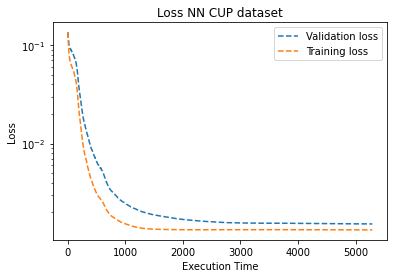

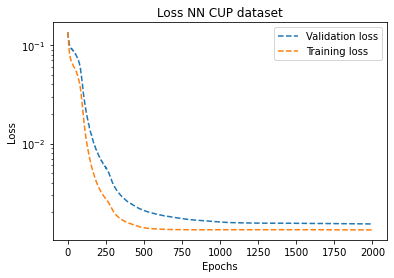

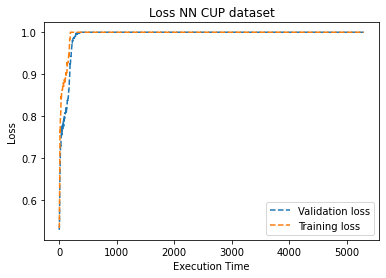

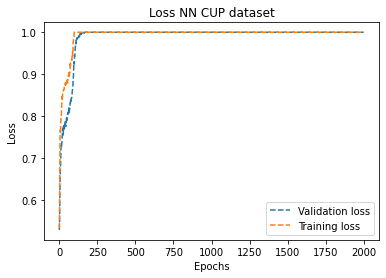

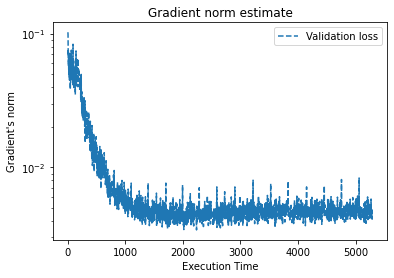

ep: 2000    | s: [5] | b: 32 | e:  0.1 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 6.47995e-03 | Loss: 1.52592e-03, 1.32821e-03 | Score:     1, 1    
ended in: 5289.763, avg per ep: 2.6448815
total update: 1.937, avg updt: 0.0009685000000000001
total ff: 12000, total ff time: 1234.5110000000018, avg ff: 0.10287591666666682
total bp: 8000, total bp time: 665.252, avg bp: 0.0831565
total ev: 2000, total ev time: 1399.387000000001, avg ev: 0.6996935000000005


----- SGD NAG -----


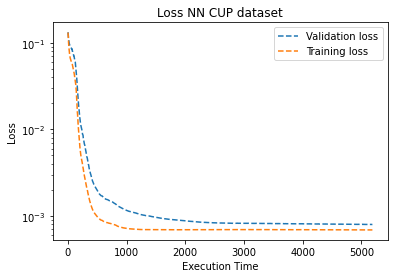

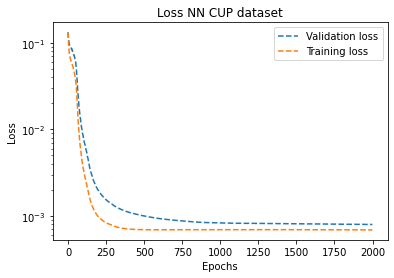

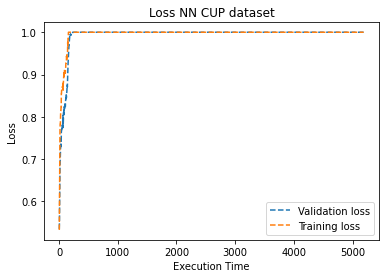

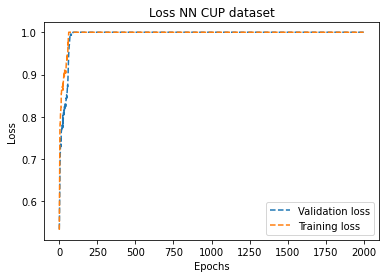

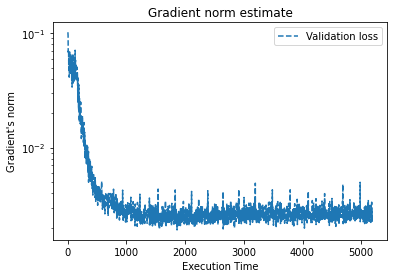

ep: 2000    | s: [5] | b: 32 | e:  0.1 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 3.42327e-03 | Loss: 7.94808e-04, 6.88332e-04 | Score:     1, 1    
ended in: 5188.152, avg per ep: 2.594076
total update: 1.839, avg updt: 0.0009195
total ff: 12000, total ff time: 1177.4869999999983, avg ff: 0.09812391666666652
total bp: 8000, total bp time: 636.8740000000004, avg bp: 0.07960925000000005
total ev: 2000, total ev time: 1348.3109999999983, avg ev: 0.6741554999999991


----- SGM -----


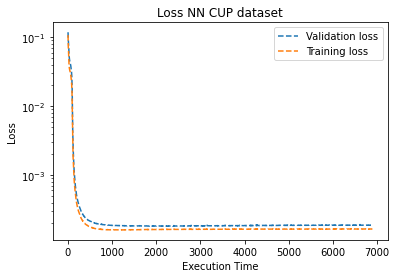

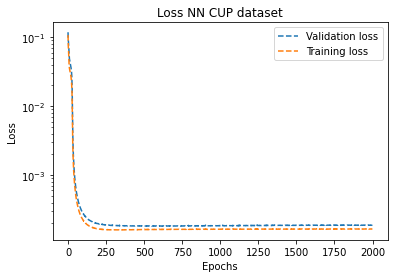

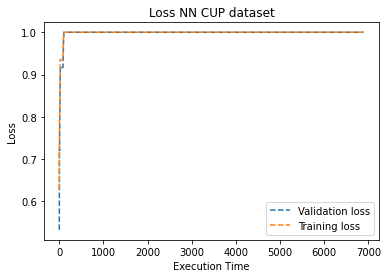

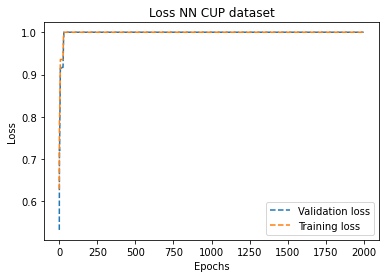

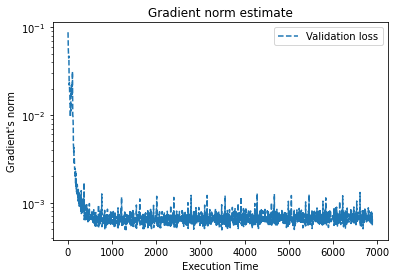

ep: 2000    | s: [5] | b: 32 | e:  0.3 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 7.93582e-04 | Loss: 1.82184e-04, 1.63433e-04 | Score:     1, 1    
ended in: 6892.972, avg per ep: 3.4464859999999997
total update: 2.353, avg updt: 0.0011765
total ff: 12000, total ff time: 1250.3720000000117, avg ff: 0.10419766666666763
total bp: 8000, total bp time: 2126.4619999999923, avg bp: 0.265807749999999
total ev: 2000, total ev time: 1368.7680000000016, avg ev: 0.6843840000000008




<Figure size 432x288 with 0 Axes>

In [9]:
print("----- SGD CM -----")
plot_net(net_SGD, dataset, 'SGD')
print("----- SGD NAG -----")
plot_net(net_SGD_nest, dataset, 'SGD_nest')
print("----- SGM -----")
plot_net(net_SGM, dataset, 'SGM')

### Monk2

In [10]:
dataset = 'monk2'

monk2 = {
    'SGD': {
        'batch_size': None,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.7,
        'lmbda': 0.01,
        'momentum': 0.9,
        'nesterov': False,
        'optimizer': "SGD",
        'sizes': [5],
        'debug': True
    },
    'SGD_nest': {
        'batch_size': None,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.7,
        'lmbda': 0.01,
        'momentum': 0.9,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [5],
        'debug': True
    },
    'SGM': {
        'batch_size': None,
        'epochs': 2000,
        'eps':1e-6,
        'eta': 0.7,
        'lmbda': 0.01,
        'optimizer': "SGM",
        'sizes': [5],
        'debug': True,
    }
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk2'])
nn = NC
    
net_SGD = nn(**monk2['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk2['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGM = nn(**monk2['SGM'])
net_SGM.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 1.41549e-01 || Loss: 1.53253e-01, 1.40251e-01 || Score: 0.424, 0.497
2       || Gradient norm: 1.19261e-01 || Loss: 1.32738e-01, 1.23947e-01 || Score: 0.521, 0.574
3       || Gradient norm: 7.19933e-02 || Loss: 1.18172e-01, 1.15370e-01 || Score: 0.604, 0.615
4       || Gradient norm: 2.05999e-02 || Loss: 1.14202e-01, 1.17379e-01 || Score:  0.66, 0.627
5       || Gradient norm: 3.98435e-02 || Loss: 1.15692e-01, 1.23092e-01 || Score: 0.667, 0.621
6       || Gradient norm: 6.09981e-02 || Loss: 1.17342e-01, 1.26771e-01 || Score: 0.669, 0.621
7       || Gradient norm: 6.71745e-02 || Loss: 1.17194e-01, 1.26935e-01 || Score: 0.669, 0.621
8       || Gradient norm: 6.69882e-02 || Loss: 1.15293e-01, 1.23963e-01 || Score: 0.669, 0.621
9       || Gradient norm: 6.10694e-02 || Loss: 1.12700e-01, 1.19232e-01 || Score: 0.667, 0.621
10      || Gradient norm: 4.93992e-02 || Loss: 1.10973e-01, 1.14694e-01 || Score: 0.653, 0.621
11      || Gradient norm: 3.26035e-02 || Loss: 1.1

NC(batch_size=169, debug=True, epochs=2000, eps=1e-06, eta=0.7, lmbda=0.01,
   optimizer='SGM', sizes=[5])

----- SGD CM -----


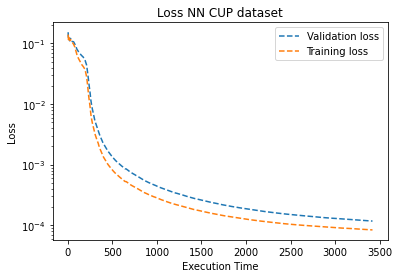

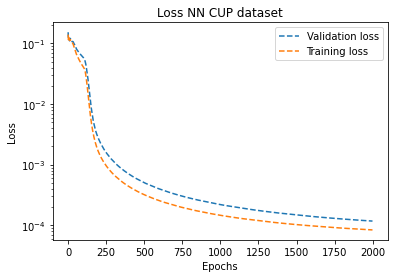

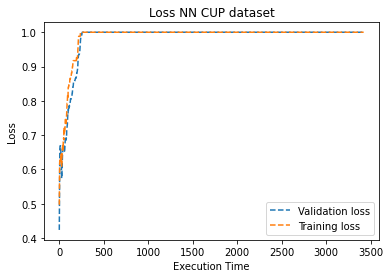

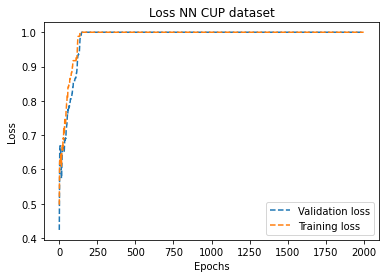

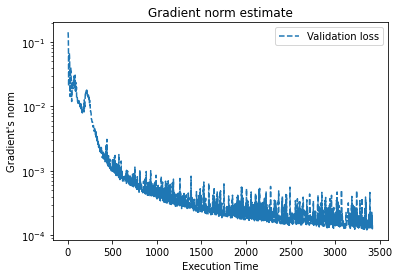

ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 1.45258e-04 | Loss: 1.17702e-04, 8.41359e-05 | Score:     1, 1    
ended in: 3420.922, avg per ep: 1.710461
total update: 1.119, avg updt: 0.0005595
total ff: 6000, total ff time: 855.9720000000018, avg ff: 0.1426620000000003
total bp: 2000, total bp time: 262.58399999999926, avg bp: 0.13129199999999963
total ev: 2000, total ev time: 1028.4550000000006, avg ev: 0.5142275000000003


----- SGD NAG -----


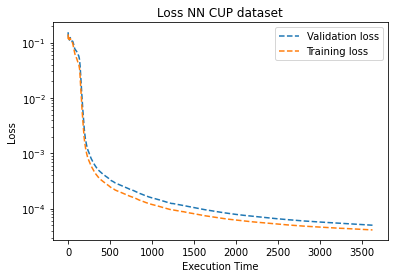

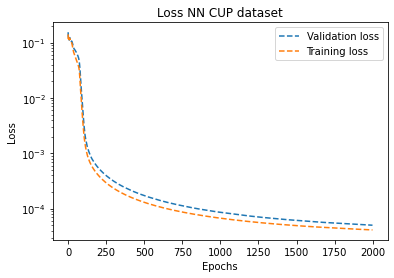

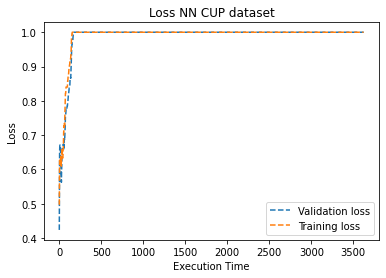

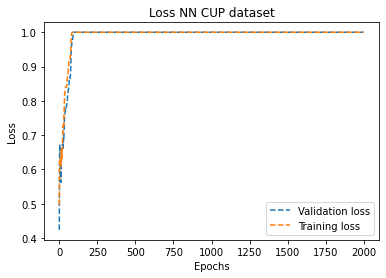

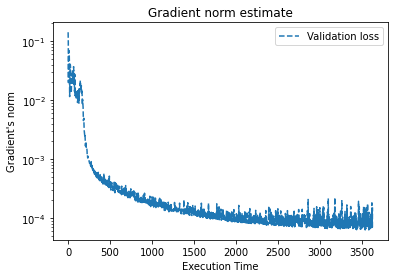

ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 1.51402e-04 | Loss: 5.03087e-05, 4.13614e-05 | Score:     1, 1    
ended in: 3623.188, avg per ep: 1.8115940000000001
total update: 1.32, avg updt: 0.00066
total ff: 6000, total ff time: 888.2719999999961, avg ff: 0.14804533333333267
total bp: 2000, total bp time: 292.52400000000034, avg bp: 0.14626200000000017
total ev: 2000, total ev time: 1071.144, avg ev: 0.535572


----- SGM -----


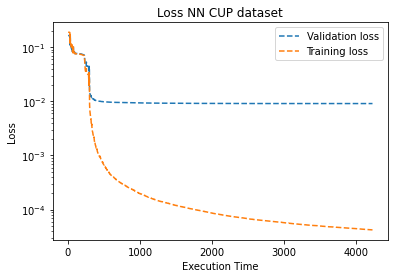

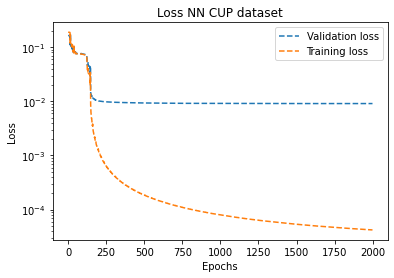

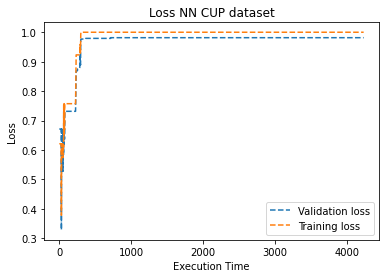

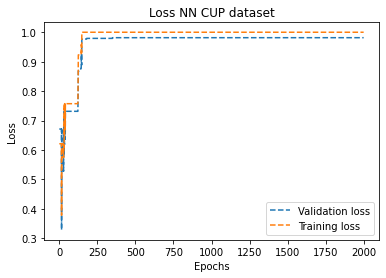

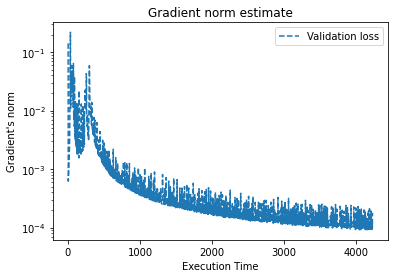

ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 1.78589e-04 | Loss: 9.10886e-03, 4.42667e-05 | Score: 0.981, 1    
ended in: 4227.991, avg per ep: 2.1139955
total update: 1.129, avg updt: 0.0005645
total ff: 6000, total ff time: 941.4129999999985, avg ff: 0.15690216666666643
total bp: 2000, total bp time: 655.0209999999977, avg bp: 0.3275104999999988
total ev: 2000, total ev time: 1125.9699999999996, avg ev: 0.5629849999999997




<Figure size 432x288 with 0 Axes>

In [11]:
print("----- SGD CM -----")
plot_net(net_SGD, dataset, 'SGD')
print("----- SGD NAG -----")
plot_net(net_SGD_nest, dataset, 'SGD_nest')
print("----- SGM -----")
plot_net(net_SGM, dataset, 'SGM')

### Monk3

In [12]:
dataset = 'monk3'

monk3 = {
     'SGD': {
        'batch_size': 32,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.5,
        'lmbda': 0.01,
        'momentum': 0.,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [2],
        'debug': True
    },
    'SGD_nest': {
        'batch_size': 32,
        'epochs': 2000,
        'eps': 1e-6,
        'eta': 0.5,
        'lmbda': 0.01,
        'momentum': 0.,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [2],
        'debug': True
    },
    'SGM': {
        'batch_size': 32,
        'epochs': 2000,
        'eps':1e-6,
        'eta': 0.7,
        'lmbda': 0.0001,
        'optimizer': "SGM",
        'sizes': [3],
        'debug': True,
    }
}
    
X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk3'])
nn = NC
    
net_SGD = nn(**monk3['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**monk3['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGM = nn(**monk3['SGM'])
net_SGM.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 6.12800e-02 || Loss: 1.28427e-01, 1.35556e-01 || Score: 0.528, 0.492
2       || Gradient norm: 5.67854e-02 || Loss: 1.22745e-01, 1.28084e-01 || Score: 0.528, 0.492
3       || Gradient norm: 9.06448e-02 || Loss: 1.20216e-01, 1.24066e-01 || Score: 0.528, 0.492
4       || Gradient norm: 3.78967e-02 || Loss: 1.18746e-01, 1.21935e-01 || Score: 0.528, 0.492
5       || Gradient norm: 7.92356e-02 || Loss: 1.17327e-01, 1.20176e-01 || Score: 0.528, 0.492
6       || Gradient norm: 4.84485e-02 || Loss: 1.15637e-01, 1.18733e-01 || Score: 0.528, 0.492
7       || Gradient norm: 7.10890e-02 || Loss: 1.14307e-01, 1.17413e-01 || Score: 0.694, 0.631
8       || Gradient norm: 5.44977e-02 || Loss: 1.13032e-01, 1.16234e-01 || Score: 0.706, 0.648
9       || Gradient norm: 7.97383e-02 || Loss: 1.11224e-01, 1.14981e-01 || Score: 0.711, 0.648
10      || Gradient norm: 4.55436e-02 || Loss: 1.09325e-01, 1.13653e-01 || Score: 0.718, 0.648
11      || Gradient norm: 5.45209e-02 || Loss: 1.0

NC(batch_size=32, debug=True, epochs=2000, eps=1e-06, eta=0.7, optimizer='SGM',
   sizes=[3])

----- SGD CM -----


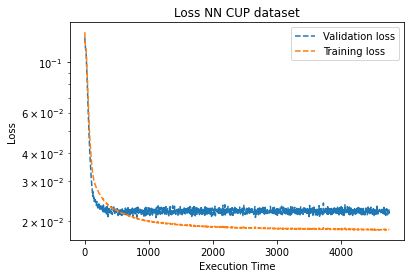

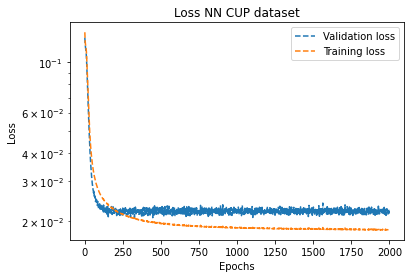

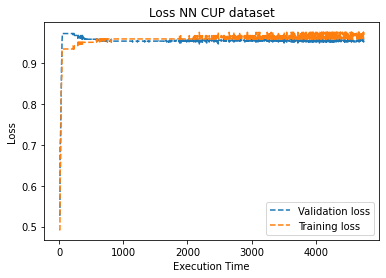

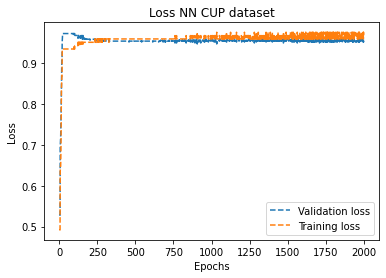

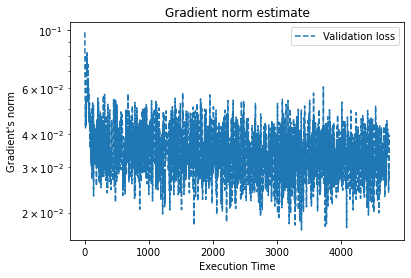

ep: 2000    | s: [2] | b: 32 | e:  0.5 | lmbda: 0.01 | m:  0.0 | nesterov: True
Grad: 3.27842e-02 | Loss: 2.07281e-02, 1.98889e-02 | Score: 0.972, 0.934
ended in: 4746.011, avg per ep: 2.3730055
total update: 1.273, avg updt: 0.0006364999999999999
total ff: 12000, total ff time: 1019.4549999999876, avg ff: 0.0849545833333323
total bp: 8000, total bp time: 568.0500000000033, avg bp: 0.07100625000000041
total ev: 2000, total ev time: 1199.1929999999984, avg ev: 0.5995964999999992


----- SGD NAG -----


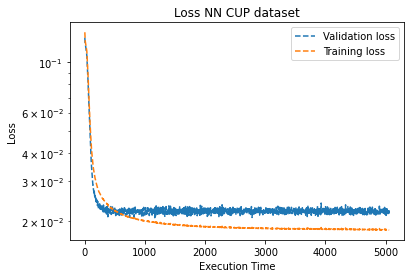

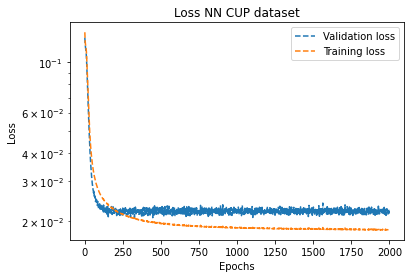

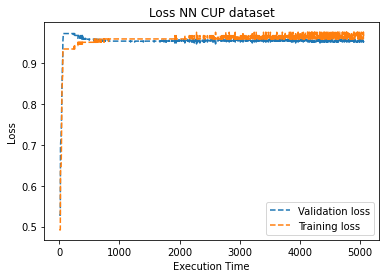

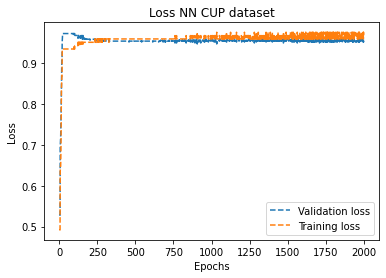

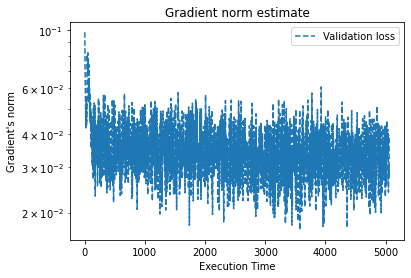

ep: 2000    | s: [2] | b: 32 | e:  0.5 | lmbda: 0.01 | m:  0.0 | nesterov: True
Grad: 3.27842e-02 | Loss: 2.07281e-02, 1.98889e-02 | Score: 0.972, 0.934
ended in: 5058.321, avg per ep: 2.5291605
total update: 1.957, avg updt: 0.0009785
total ff: 12000, total ff time: 1085.4440000000059, avg ff: 0.09045366666666715
total bp: 8000, total bp time: 587.4620000000034, avg bp: 0.07343275000000042
total ev: 2000, total ev time: 1279.764000000003, avg ev: 0.6398820000000015


----- SGM -----


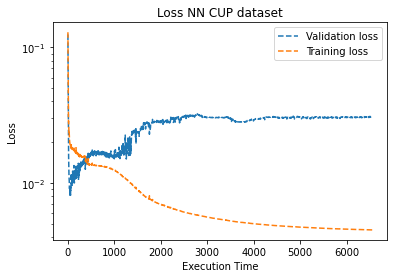

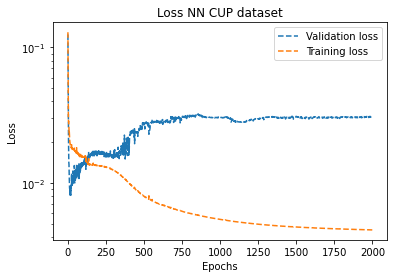

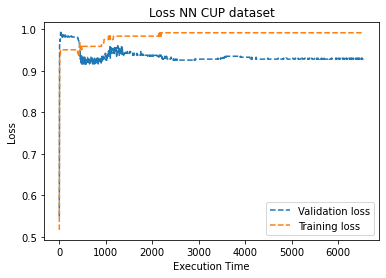

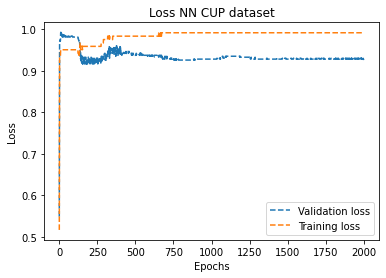

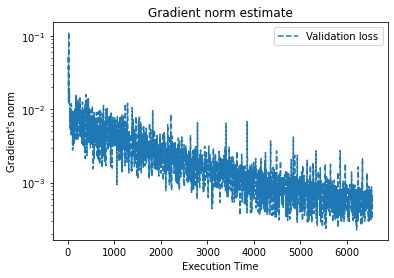

ep: 2000    | s: [3] | b: 32 | e:  0.7 | lmbda:0.0001 | m:  0.5 | nesterov: False
Grad: 1.58566e-04 | Loss: 7.96333e-03, 1.90778e-02 | Score: 0.993, 0.951
ended in: 6551.918, avg per ep: 3.275959
total update: 2.779, avg updt: 0.0013895
total ff: 12000, total ff time: 1144.201999999992, avg ff: 0.095350166666666
total bp: 8000, total bp time: 2011.0999999999908, avg bp: 0.2513874999999989
total ev: 2000, total ev time: 1283.485000000001, avg ev: 0.6417425000000005




<Figure size 432x288 with 0 Axes>

In [13]:
print("----- SGD CM -----")
plot_net(net_SGD, dataset, 'SGD')
print("----- SGD NAG -----")
plot_net(net_SGD_nest, dataset, 'SGD_nest')
print("----- SGM -----")
plot_net(net_SGM, dataset, 'SGM')

### CUP

In [8]:
dataset = 'cup'

cup = {
    'SGD': {
        'activation': 'Lrelu',
        'batch_size': 32,
        'epochs': 1000,
        'eps': 1e-6,
        'eta': 0.001,
        'lmbda': 0.001,
        'momentum': 0.,
        'optimizer': "SGD",
        'sizes': [30, 50],
        'debug': True
    },
    'SGD_nest': {
        'activation': 'Lrelu',
        'batch_size': 32,
        'epochs': 1000,
        'eps': 1e-6,
        'eta': 0.001,
        'lmbda': 0.001,
        'momentum': 0.,
        'nesterov': True,
        'optimizer': "SGD",
        'sizes': [30, 50],
        'debug': True
    },
    'SGM': {
        'batch_size': 32,
        'epochs': 1000,
        'eps':1e-6,
        'eta': 0.01,
        'lmbda': 0.,
        'optimizer': "SGM",
        'sizes': [50, 50],
        'debug': True
    }
}
    
X_train, X_test, y_train, y_test = utils.load_CUP(datasets['cup'])
nn = NR
    
net_SGD = nn(**cup['SGD'])
net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGD_nest = nn(**cup['SGD_nest'])
net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))

net_SGM = nn(**cup['SGM'])
net_SGM.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 1.84887e+02 || Loss: 2.69158e+01, 2.71774e+01 || Score: 0.629, 0.612
2       || Gradient norm: 1.66971e+02 || Loss: 1.93475e+01, 1.97801e+01 || Score: 0.739, 0.724
3       || Gradient norm: 1.48138e+02 || Loss: 1.48344e+01, 1.52020e+01 || Score: 0.802, 0.79 
4       || Gradient norm: 1.37697e+02 || Loss: 1.25459e+01, 1.27936e+01 || Score: 0.833, 0.821
5       || Gradient norm: 1.26916e+02 || Loss: 1.11958e+01, 1.13531e+01 || Score:  0.85, 0.839
6       || Gradient norm: 1.16566e+02 || Loss: 1.01756e+01, 1.02499e+01 || Score: 0.863, 0.853
7       || Gradient norm: 1.10329e+02 || Loss: 9.41682e+00, 9.35329e+00 || Score: 0.872, 0.865
8       || Gradient norm: 1.05684e+02 || Loss: 8.81966e+00, 8.63142e+00 || Score:  0.88, 0.875
9       || Gradient norm: 1.00229e+02 || Loss: 8.36413e+00, 8.08507e+00 || Score: 0.886, 0.882
10      || Gradient norm: 9.82960e+01 || Loss: 7.98413e+00, 7.64177e+00 || Score: 0.891, 0.888
11      || Gradient norm: 9.73266e+01 || Loss: 7.6

NR(batch_size=32, debug=True, eps=1e-06, optimizer='SGM', sizes=[50, 50])

----- SGD CM -----


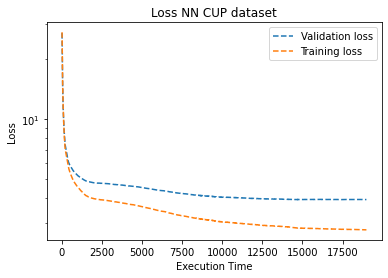

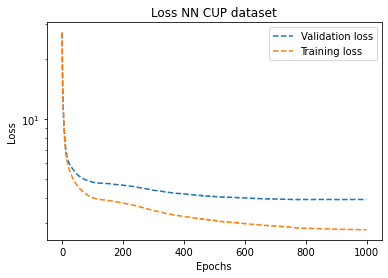

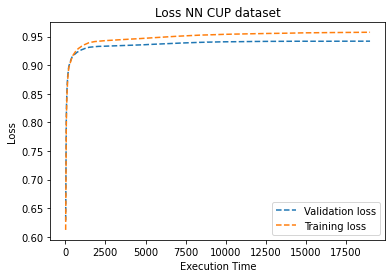

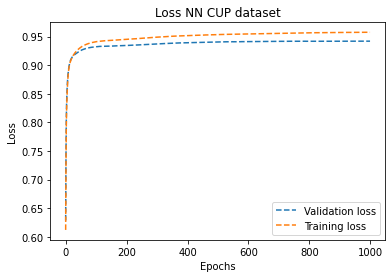

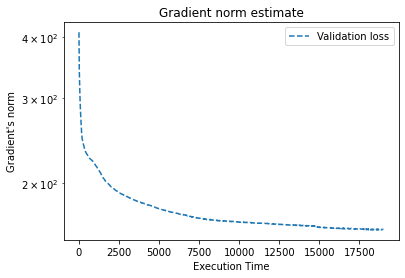

ep: 1000    | s: [30, 50] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0 | nesterov: False
Grad: 6.09673e+01 | Loss: 3.93305e+00, 2.84479e+00 | Score: 0.942, 0.958
ended in: 18987.153, avg per ep: 18.987153
total update: 12.474, avg updt: 0.012474
total ff: 36000, total ff time: 6619.335000000001, avg ff: 0.1838704166666667
total bp: 34000, total bp time: 5943.089999999978, avg bp: 0.1747967647058817
total ev: 1000, total ev time: 4514.353999999996, avg ev: 4.5143539999999955


----- SGD NAG -----


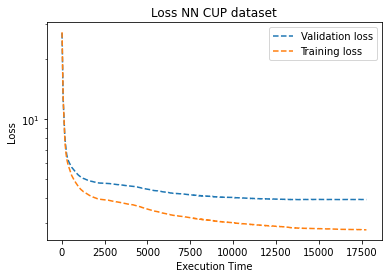

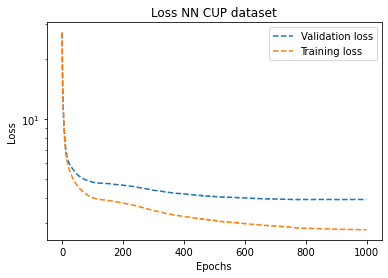

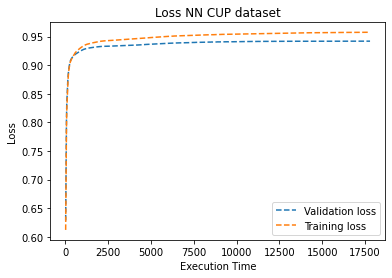

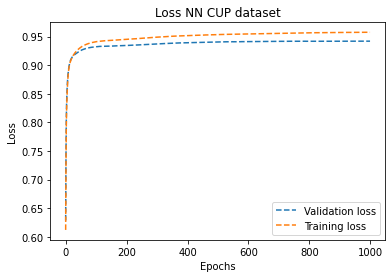

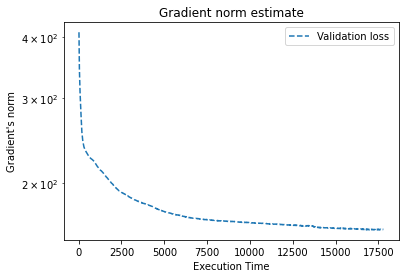

ep: 1000    | s: [30, 50] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0 | nesterov: True
Grad: 6.09673e+01 | Loss: 3.93305e+00, 2.84479e+00 | Score: 0.942, 0.958
ended in: 17785.719, avg per ep: 17.785719
total update: 15.146, avg updt: 0.015146000000000001
total ff: 36000, total ff time: 5886.19800000011, avg ff: 0.16350550000000308
total bp: 34000, total bp time: 5286.980999999981, avg bp: 0.15549944117647002
total ev: 1000, total ev time: 4058.4809999999993, avg ev: 4.058481


----- SGM -----


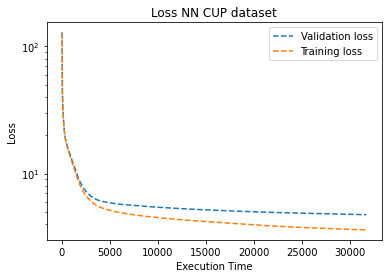

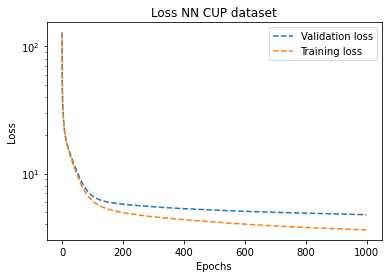

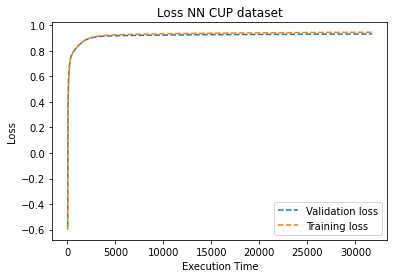

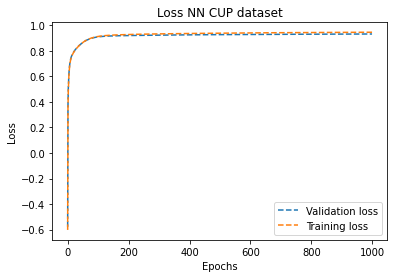

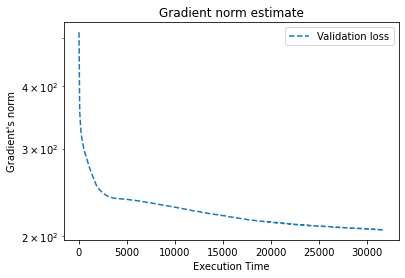

ep: 1000    | s: [50, 50] | b: 32 | e: 0.01 | lmbda:  0.0 | m:  0.0 | nesterov: False
Grad: 7.07336e+01 | Loss: 4.75835e+00, 3.61337e+00 | Score: 0.933, 0.946
ended in: 31726.739, avg per ep: 31.726739000000002
total update: 35.266, avg updt: 0.035266
total ff: 36000, total ff time: 7022.461000000287, avg ff: 0.19506836111111908
total bp: 34000, total bp time: 16313.201999999967, avg bp: 0.47980005882352844
total ev: 1000, total ev time: 4704.051000000004, avg ev: 4.704051000000004




<Figure size 432x288 with 0 Axes>

In [9]:
print("----- SGD CM -----")
plot_net(net_SGD, dataset, 'SGD')
print("----- SGD NAG -----")
plot_net(net_SGD_nest, dataset, 'SGD_nest')
print("----- SGM -----")
plot_net(net_SGM, dataset, 'SGM')

# Test convergence to given precision

In [10]:
# TODO: aggiungere json di configurazione
params_conv = {
    'cup': {
        'SGD': {
            'batch_size': 32,
            'epochs': 1000,
            'eps': 1e-6,
            'eta': 0.001,
            'lmbda': 0.001,
            'momentum': 0.,
            'optimizer': "SGD",
            'sizes': [30, 50],
            'activation': 'Lrelu',
            'debug': True,
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 1000,
            'eps':1e-6,
            'eta': 0.01,
            'lmbda': 0.,
            'optimizer': "SGM",
            'sizes': [50, 50],
            'activation': 'Lrelu',
            'debug': True,
        }
    },
    'monk1': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': 32,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.5,
            'lmbda': 0.001,
            'momentum': 0.9,
            'nesterov': True,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.5,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True
        }
    },
    'monk2': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': None,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.7,
            'lmbda': 0.01,
            'momentum': 0.9,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': None,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.7,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True,
        }
    },
    'monk3': {
        'SGD': {
            'activation': 'Lrelu',
            'batch_size': 32,
            'epochs': 2000,
            'eps': 1e-6,
            'eta': 0.7,
            'lmbda': 0.001,
            'momentum': 0.5,
            'nesterov': True,
            'optimizer': "SGD",
            'sizes': [5],
            'debug': True
        },
        'SGM': {
            'batch_size': 32,
            'epochs': 2000,
            'eps':1e-6,
            'eta': 0.7,
            'lmbda': 0.01,
            'optimizer': "SGM",
            'sizes': [5],
            'debug': True,
        }
    }
}

## SGD

In [11]:
test = "SGD"
dataset = "monk1"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 7.67511e-01 || Loss: 1.32065e-01, 1.25099e-01 || Score: 0.512, 0.5  
2       || Gradient norm: 3.62820e-01 || Loss: 1.14028e-01, 1.01192e-01 || Score:  0.66, 0.782
3       || Gradient norm: 3.69657e-01 || Loss: 1.09925e-01, 9.15985e-02 || Score: 0.646, 0.766
4       || Gradient norm: 5.71114e-01 || Loss: 9.97688e-02, 7.91875e-02 || Score: 0.725, 0.774
5       || Gradient norm: 7.06277e-01 || Loss: 1.01122e-01, 7.30566e-02 || Score: 0.713, 0.806
6       || Gradient norm: 7.19420e-01 || Loss: 1.03949e-01, 7.14689e-02 || Score: 0.704, 0.79 
7       || Gradient norm: 7.23070e-01 || Loss: 9.56722e-02, 6.97206e-02 || Score: 0.741, 0.823
8       || Gradient norm: 6.10397e-01 || Loss: 9.92841e-02, 6.88058e-02 || Score: 0.706, 0.79 
9       || Gradient norm: 6.66296e-01 || Loss: 9.32319e-02, 6.68831e-02 || Score: 0.736, 0.823
10      || Gradient norm: 7.14635e-01 || Loss: 9.48050e-02, 6.44335e-02 || Score: 0.715, 0.815
11      || Gradient norm: 7.15648e-01 || Loss: 9.0

NC(batch_size=32, debug=True, epochs=2000, eps=1e-06, eta=0.5, lmbda=0.001,
   momentum=0.9, nesterov=True, sizes=[5])

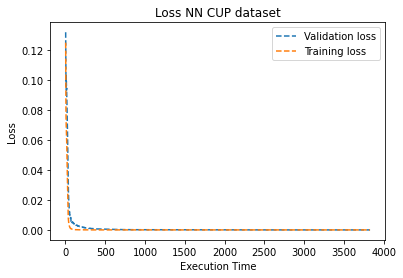

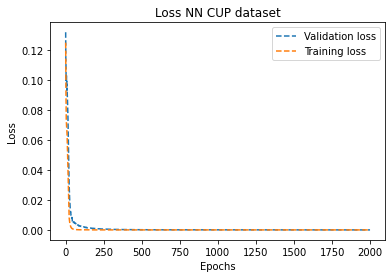

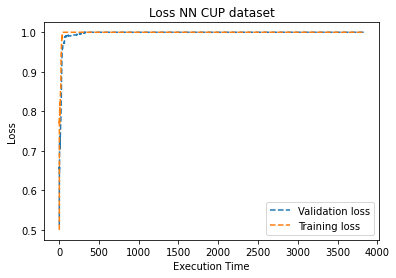

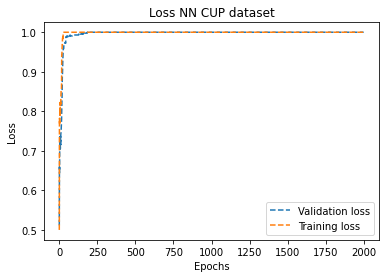

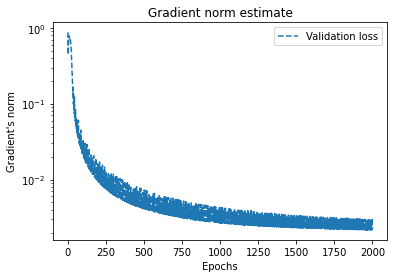

ep: 2000    | s: [5] | b: 32 | e:  0.5 | lmbda:0.001 | m:  0.9 | nesterov: True
Grad: 2.17726e-03 | Loss: 3.01498e-06, 1.58982e-07 | Score:     1, 1    
ended in: 3828.718, avg per ep: 1.914359
total update: 1.498, avg updt: 0.000749
total ff: 12000, total ff time: 1404.8920000000126, avg ff: 0.11707433333333438
total bp: 8000, total bp time: 647.9170000000014, avg bp: 0.08098962500000018
total ev: 2000, total ev time: 1610.284999999999, avg ev: 0.8051424999999994




<Figure size 432x288 with 0 Axes>

In [12]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

In [13]:
test = "SGD"
dataset = "monk2"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 2.11512e+00 || Loss: 1.52054e-01, 1.39262e-01 || Score: 0.428, 0.509
2       || Gradient norm: 1.99542e+00 || Loss: 1.31108e-01, 1.22832e-01 || Score: 0.532, 0.568
3       || Gradient norm: 1.85070e+00 || Loss: 1.17298e-01, 1.15078e-01 || Score: 0.606, 0.609
4       || Gradient norm: 1.76541e+00 || Loss: 1.13967e-01, 1.17600e-01 || Score:  0.66, 0.627
5       || Gradient norm: 1.75004e+00 || Loss: 1.15244e-01, 1.22704e-01 || Score: 0.667, 0.621
6       || Gradient norm: 1.75335e+00 || Loss: 1.15829e-01, 1.24639e-01 || Score: 0.669, 0.621
7       || Gradient norm: 1.68283e+00 || Loss: 1.14323e-01, 1.22503e-01 || Score: 0.669, 0.621
8       || Gradient norm: 1.57173e+00 || Loss: 1.11893e-01, 1.17990e-01 || Score: 0.662, 0.621
9       || Gradient norm: 1.42396e+00 || Loss: 1.10581e-01, 1.13826e-01 || Score: 0.648, 0.615
10      || Gradient norm: 1.28709e+00 || Loss: 1.11528e-01, 1.11913e-01 || Score: 0.637, 0.621
11      || Gradient norm: 1.17225e+00 || Loss: 1.1

NC(batch_size=169, debug=True, epochs=2000, eps=1e-06, eta=0.7, lmbda=0.01,
   momentum=0.9, sizes=[5])

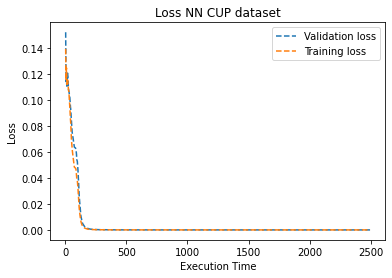

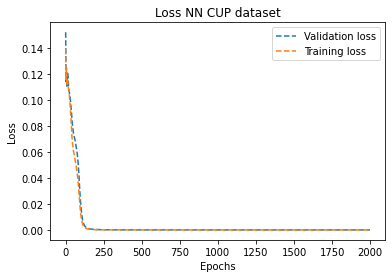

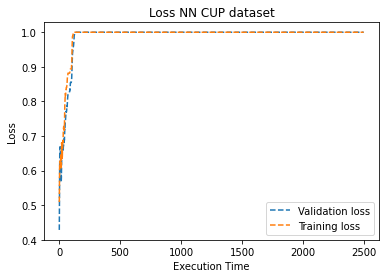

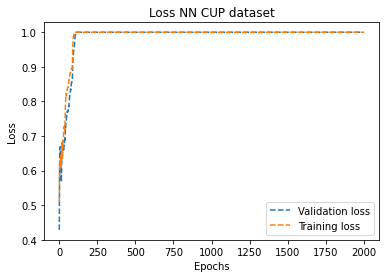

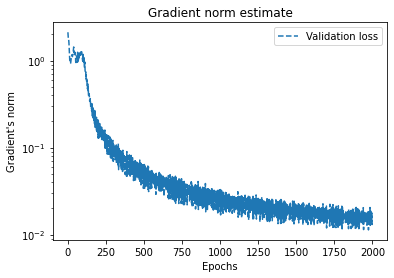

ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 1.39787e-02 | Loss: 1.06248e-06, 7.09534e-07 | Score:     1, 1    
ended in: 2495.25, avg per ep: 1.247625
total update: 0.773, avg updt: 0.0003865
total ff: 6000, total ff time: 1065.4109999999991, avg ff: 0.17756849999999985
total bp: 2000, total bp time: 379.6139999999996, avg bp: 0.18980699999999978
total ev: 2000, total ev time: 1227.8879999999983, avg ev: 0.6139439999999992




<Figure size 432x288 with 0 Axes>

In [14]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

In [15]:
test = "SGD"
dataset = "monk3"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 6.58239e-01 || Loss: 9.37277e-02, 9.10558e-02 || Score: 0.736, 0.787
2       || Gradient norm: 6.26391e-01 || Loss: 6.54816e-02, 6.50991e-02 || Score: 0.896, 0.902
3       || Gradient norm: 5.99121e-01 || Loss: 4.69477e-02, 4.81247e-02 || Score: 0.963, 0.926
4       || Gradient norm: 6.03418e-01 || Loss: 3.34527e-02, 3.81903e-02 || Score: 0.972, 0.934
5       || Gradient norm: 5.76797e-01 || Loss: 2.71119e-02, 3.32747e-02 || Score: 0.972, 0.934
6       || Gradient norm: 5.75543e-01 || Loss: 2.26679e-02, 3.05858e-02 || Score: 0.972, 0.934
7       || Gradient norm: 5.80568e-01 || Loss: 2.04967e-02, 2.90343e-02 || Score: 0.972, 0.934
8       || Gradient norm: 5.87719e-01 || Loss: 1.91458e-02, 2.80100e-02 || Score: 0.972, 0.934
9       || Gradient norm: 5.94099e-01 || Loss: 1.83776e-02, 2.72308e-02 || Score: 0.972, 0.934
10      || Gradient norm: 5.94941e-01 || Loss: 1.77817e-02, 2.66117e-02 || Score: 0.972, 0.934
11      || Gradient norm: 5.99422e-01 || Loss: 1.7

NC(batch_size=32, debug=True, epochs=2000, eps=1e-06, eta=0.7, lmbda=0.001,
   nesterov=True, sizes=[5])

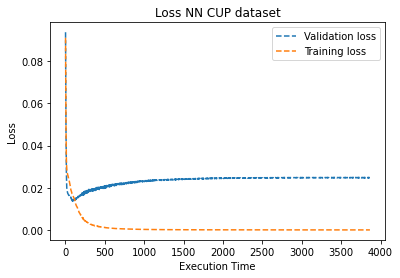

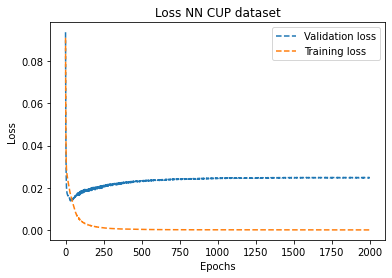

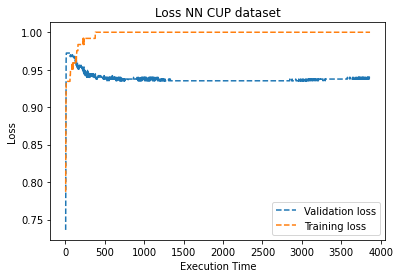

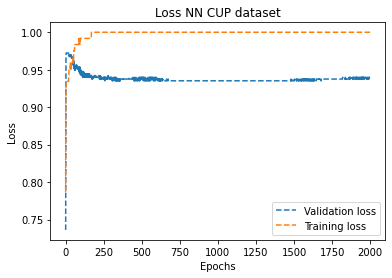

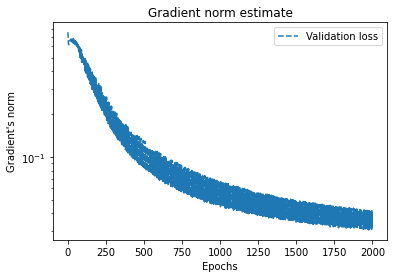

ep: 2000    | s: [5] | b: 32 | e:  0.7 | lmbda:0.001 | m:  0.5 | nesterov: True
Grad: 4.99692e-02 | Loss: 1.36661e-02, 1.62530e-02 | Score: 0.972, 0.934
ended in: 3865.533, avg per ep: 1.9327665
total update: 1.246, avg updt: 0.000623
total ff: 12000, total ff time: 1443.9140000000057, avg ff: 0.12032616666666714
total bp: 8000, total bp time: 656.5869999999998, avg bp: 0.08207337499999998
total ev: 2000, total ev time: 1626.8549999999984, avg ev: 0.8134274999999992




<Figure size 432x288 with 0 Axes>

In [16]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

## SGM

In [17]:
test = "SGM"
dataset = "monk1"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 3.10457e-01 || Loss: 1.29083e-01, 1.27418e-01 || Score:   0.5, 0.5  
2       || Gradient norm: 3.40555e-01 || Loss: 1.17124e-01, 1.07827e-01 || Score: 0.597, 0.685
3       || Gradient norm: 3.57122e-01 || Loss: 9.51374e-02, 8.42628e-02 || Score: 0.623, 0.718
4       || Gradient norm: 3.24295e-01 || Loss: 8.42866e-02, 7.38234e-02 || Score: 0.609, 0.71 
5       || Gradient norm: 2.47777e-01 || Loss: 8.13419e-02, 6.55659e-02 || Score: 0.606, 0.694
6       || Gradient norm: 3.75915e-01 || Loss: 9.13913e-02, 6.46238e-02 || Score: 0.648, 0.734
7       || Gradient norm: 4.98251e-01 || Loss: 7.42344e-02, 5.90994e-02 || Score: 0.553, 0.613
8       || Gradient norm: 5.15706e-01 || Loss: 8.28793e-02, 6.08457e-02 || Score: 0.646, 0.758
9       || Gradient norm: 5.75177e-01 || Loss: 8.48260e-02, 6.09324e-02 || Score: 0.637, 0.758
10      || Gradient norm: 4.67304e-01 || Loss: 6.02450e-02, 5.11586e-02 || Score:  0.81, 0.839
11      || Gradient norm: 5.43897e-01 || Loss: 5.6

NC(batch_size=32, debug=True, epochs=2000, eps=1e-06, eta=0.5, lmbda=0.01,
   optimizer='SGM', sizes=[5])

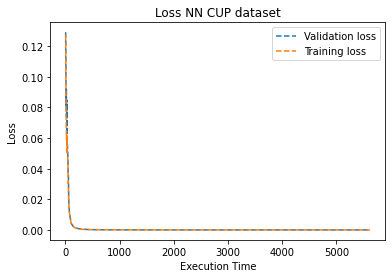

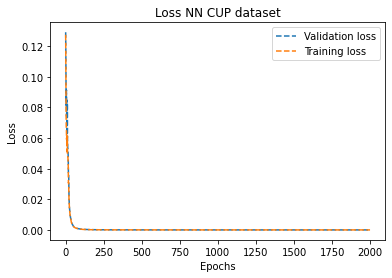

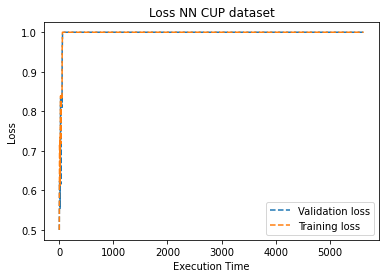

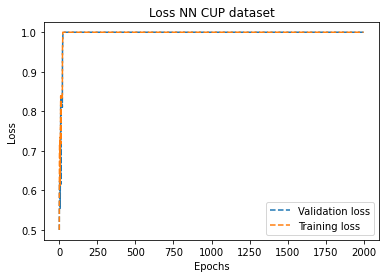

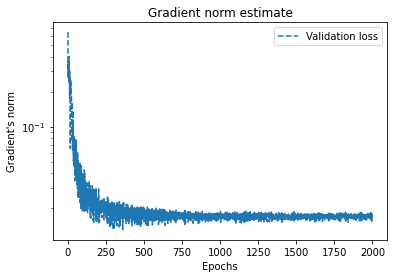

ep: 2000    | s: [5] | b: 32 | e:  0.5 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 2.71522e-02 | Loss: 1.24611e-05, 8.06819e-06 | Score:     1, 1    
ended in: 5621.763, avg per ep: 2.8108815
total update: 2.232, avg updt: 0.001116
total ff: 12000, total ff time: 1453.922000000003, avg ff: 0.12116016666666692
total bp: 8000, total bp time: 2291.280999999996, avg bp: 0.28641012499999946
total ev: 2000, total ev time: 1604.2359999999992, avg ev: 0.8021179999999996




<Figure size 432x288 with 0 Axes>

In [18]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

In [19]:
test = "SGM"
dataset = "monk2"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 2.11512e+00 || Loss: 1.64264e-01, 1.89244e-01 || Score: 0.671, 0.621
2       || Gradient norm: 2.90274e+00 || Loss: 1.12850e-01, 1.15882e-01 || Score: 0.641, 0.604
3       || Gradient norm: 1.11475e+00 || Loss: 1.11379e-01, 1.14305e-01 || Score: 0.634, 0.592
4       || Gradient norm: 1.11085e+00 || Loss: 1.11159e-01, 1.13178e-01 || Score: 0.639, 0.615
5       || Gradient norm: 1.09618e+00 || Loss: 1.10840e-01, 1.12242e-01 || Score: 0.611, 0.604
6       || Gradient norm: 1.09269e+00 || Loss: 1.10385e-01, 1.11636e-01 || Score: 0.609, 0.598
7       || Gradient norm: 1.09029e+00 || Loss: 1.10079e-01, 1.10753e-01 || Score: 0.597, 0.586
8       || Gradient norm: 1.05271e+00 || Loss: 1.09405e-01, 1.09678e-01 || Score: 0.581, 0.586
9       || Gradient norm: 1.01977e+00 || Loss: 1.08220e-01, 1.08311e-01 || Score:  0.56, 0.55 
10      || Gradient norm: 1.00216e+00 || Loss: 1.06486e-01, 1.06306e-01 || Score: 0.537, 0.538
11      || Gradient norm: 9.53688e-01 || Loss: 1.0

NC(batch_size=169, debug=True, epochs=2000, eps=1e-06, eta=0.7, lmbda=0.01,
   optimizer='SGM', sizes=[5])

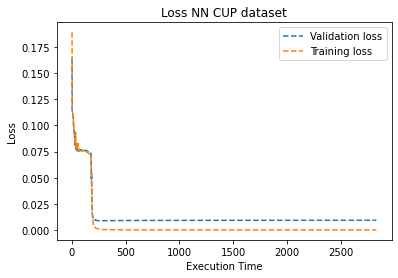

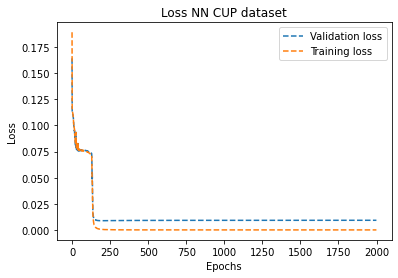

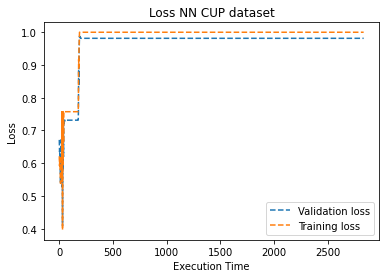

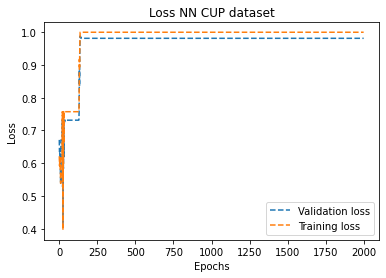

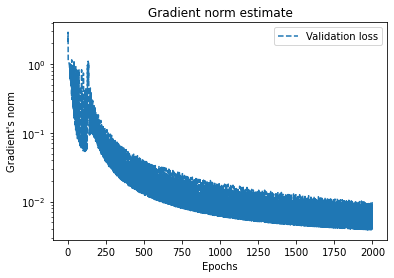

ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.5 | nesterov: False
Grad: 3.89406e-03 | Loss: 8.82443e-03, 4.51599e-04 | Score: 0.988, 1    
ended in: 2833.417, avg per ep: 1.4167085
total update: 0.525, avg updt: 0.00026250000000000004
total ff: 6000, total ff time: 1023.4789999999988, avg ff: 0.17057983333333313
total bp: 2000, total bp time: 739.3549999999987, avg bp: 0.3696774999999993
total ev: 2000, total ev time: 1173.6569999999979, avg ev: 0.586828499999999




<Figure size 432x288 with 0 Axes>

In [20]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

In [21]:
test = "SGD"
dataset = "monk3"
eps = 1e-4

if dataset == 'cup':
    X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset], split=0.2)
    nn = NR
else:
    X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
    nn = NC
    
# params_conv[dataset][test]['eps'] = eps
# params_conv[dataset][test]['epochs'] = 10000
net = nn(**params_conv[dataset][test])
net.fit(X_train, y_train, test_data=(X_test, y_test))

1       || Gradient norm: 6.58239e-01 || Loss: 9.37277e-02, 9.10558e-02 || Score: 0.736, 0.787
2       || Gradient norm: 6.26391e-01 || Loss: 6.54816e-02, 6.50991e-02 || Score: 0.896, 0.902
3       || Gradient norm: 5.99121e-01 || Loss: 4.69477e-02, 4.81247e-02 || Score: 0.963, 0.926
4       || Gradient norm: 6.03418e-01 || Loss: 3.34527e-02, 3.81903e-02 || Score: 0.972, 0.934
5       || Gradient norm: 5.76797e-01 || Loss: 2.71119e-02, 3.32747e-02 || Score: 0.972, 0.934
6       || Gradient norm: 5.75543e-01 || Loss: 2.26679e-02, 3.05858e-02 || Score: 0.972, 0.934
7       || Gradient norm: 5.80568e-01 || Loss: 2.04967e-02, 2.90343e-02 || Score: 0.972, 0.934
8       || Gradient norm: 5.87719e-01 || Loss: 1.91458e-02, 2.80100e-02 || Score: 0.972, 0.934
9       || Gradient norm: 5.94099e-01 || Loss: 1.83776e-02, 2.72308e-02 || Score: 0.972, 0.934
10      || Gradient norm: 5.94941e-01 || Loss: 1.77817e-02, 2.66117e-02 || Score: 0.972, 0.934
11      || Gradient norm: 5.99422e-01 || Loss: 1.7

NC(batch_size=32, debug=True, epochs=2000, eps=1e-06, eta=0.7, lmbda=0.001,
   nesterov=True, sizes=[5])

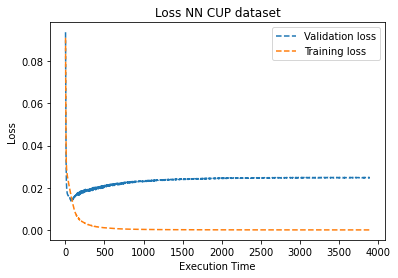

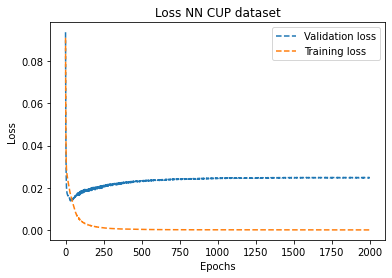

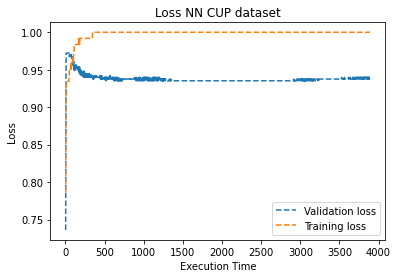

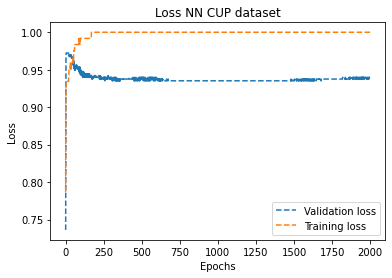

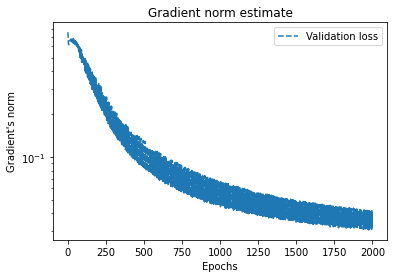

ep: 2000    | s: [5] | b: 32 | e:  0.7 | lmbda:0.001 | m:  0.5 | nesterov: True
Grad: 4.99692e-02 | Loss: 1.36661e-02, 1.62530e-02 | Score: 0.972, 0.934
ended in: 3891.38, avg per ep: 1.9456900000000001
total update: 1.032, avg updt: 0.000516
total ff: 12000, total ff time: 1461.334, avg ff: 0.12177783333333334
total bp: 8000, total bp time: 661.7530000000006, avg bp: 0.08271912500000007
total ev: 2000, total ev time: 1659.0600000000022, avg ev: 0.8295300000000011




<Figure size 432x288 with 0 Axes>

In [22]:
net.plot_results(f"{dataset}_{test}", score=False, time=True)
net.plot_results(f"{dataset}_{test}", score=False, time=False)
net.plot_results(f"{dataset}_{test}", score=True, time=True)
net.plot_results(f"{dataset}_{test}", score=True, time=False)
net.plot_grad(f"{dataset}_{test}")

print(net.best_score(name=f"{dataset}_{test}", save=False))

# Report stats

## Monk1

In [6]:
debug = False
score = False
dataset = 'monk1'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.5, 'lmbda': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 32 | e:  0.5 | lmbda:0.001 | m:  0.9 | nesterov: True
Grad: 2.89981e-04 | Loss: -1.00000e+00, 1.58541e-07 | Score:    -1, 1    
ended in: 2173.889, avg per ep: 1.0869445
total update: 0.765, avg updt: 0.00038250000000000003
total ff: 10000, total ff time: 533.0039999999951, avg ff: 0.05330039999999951
total bp: 8000, total bp time: 550.2759999999953, avg bp: 0.06878449999999942
total ev: 2000, total ev time: 299.52499999999964, avg ev: 0.14976249999999983

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.5, 'lmbda': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 32 | e:  0.5 | lmbda:0.001 | m:  0.9 | nesterov: True
Grad: 2.89981e-04 | Lo

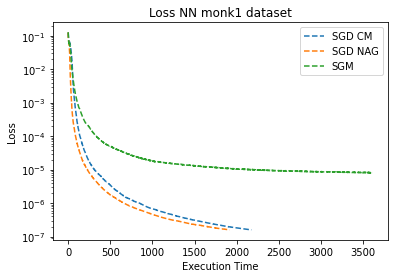

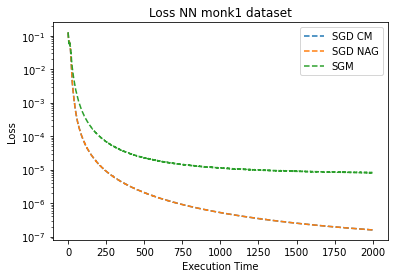

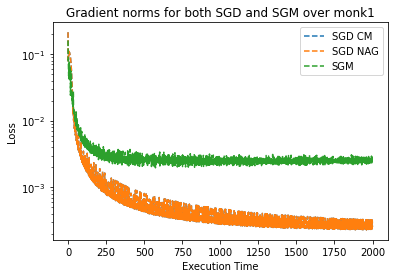

<Figure size 432x288 with 0 Axes>

In [7]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## Monk2

In [8]:
debug = False
score = False
dataset = 'monk2'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.7, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: False
Grad: 3.83346e-04 | Loss: -1.00000e+00, 7.09534e-07 | Score:    -1, 1    
ended in: 895.65, avg per ep: 0.447825
total update: 0.314, avg updt: 0.000157
total ff: 4000, total ff time: 268.66400000000164, avg ff: 0.0671660000000004
total bp: 2000, total bp time: 191.10099999999872, avg bp: 0.09555049999999936
total ev: 2000, total ev time: 298.066000000001, avg ev: 0.1490330000000005

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': None, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.7, 'lmbda': 0.01, 'momentum': 0.9, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 169 | e:  0.7 | lmbda: 0.01 | m:  0.9 | nesterov: True
Grad: 1.56601e-04 | Loss: -1.00000e+00, 1.76782e-07 | Score:    -1, 1    

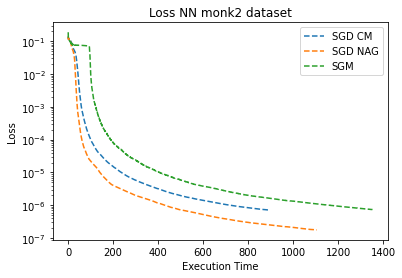

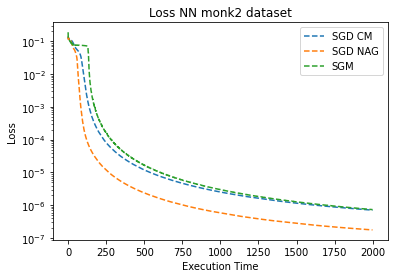

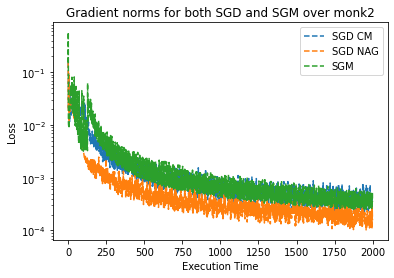

<Figure size 432x288 with 0 Axes>

In [9]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## Monk3

In [10]:
debug = False
score = False
dataset = 'monk3'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.7, 'lmbda': 0.001, 'momentum': 0.5, 'nesterov': True, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 32 | e:  0.7 | lmbda:0.001 | m:  0.5 | nesterov: True
Grad: 3.73444e-03 | Loss: -1.00000e+00, 1.57477e-05 | Score:    -1, 1    
ended in: 2404.13, avg per ep: 1.2020650000000002
total update: 0.7, avg updt: 0.00035
total ff: 10000, total ff time: 598.2490000000049, avg ff: 0.05982490000000049
total bp: 8000, total bp time: 605.2349999999999, avg bp: 0.07565437499999998
total ev: 2000, total ev time: 329.9790000000003, avg ev: 0.16498950000000015

 

----- SGD nesterov-----
{'activation': 'Lrelu', 'batch_size': 32, 'epochs': 2000, 'eps': 1e-06, 'eta': 0.7, 'lmbda': 0.001, 'momentum': 0.5, 'nesterov': True, 'optimizer': 'SGD', 'sizes': [5], 'debug': True}
ep: 2000    | s: [5] | b: 32 | e:  0.7 | lmbda:0.001 | m:  0.5 | nesterov: True
Grad: 3.73444e-03 | Loss: -1.000

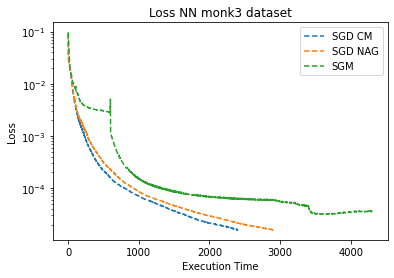

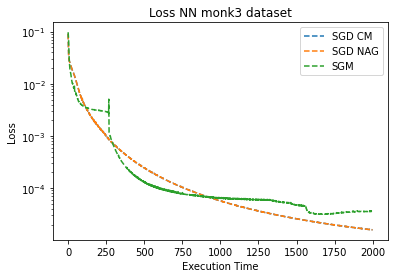

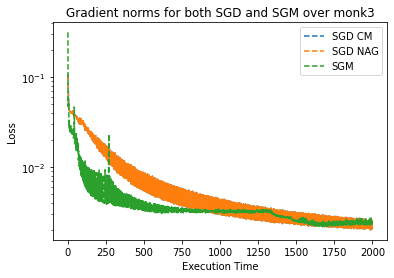

<Figure size 432x288 with 0 Axes>

In [11]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)

## CUP

In [12]:
debug = False
score = False
dataset = 'cup'
net_SGD, net_SGD_nest, net_SGM = report_stats(dataset, score=score, debug=debug)

----- SGD -----
{'batch_size': 32, 'epochs': 1000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.0, 'optimizer': 'SGD', 'sizes': [30, 50], 'activation': 'Lrelu', 'debug': True}
ep: 1000    | s: [30, 50] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0 | nesterov: False
Grad: 3.75936e+01 | Loss: -1.00000e+00, 2.77330e+00 | Score:    -1, 0.958
ended in: 16073.872, avg per ep: 16.073871999999998
total update: 11.455, avg updt: 0.011455
total ff: 35000, total ff time: 5070.278000000366, avg ff: 0.14486508571429615
total bp: 34000, total bp time: 5253.797000000046, avg bp: 0.15452344117647193
total ev: 1000, total ev time: 2096.721999999996, avg ev: 2.096721999999996

 

----- SGD nesterov-----
{'batch_size': 32, 'epochs': 1000, 'eps': 1e-06, 'eta': 0.001, 'lmbda': 0.001, 'momentum': 0.0, 'optimizer': 'SGD', 'sizes': [30, 50], 'activation': 'Lrelu', 'debug': True}
ep: 1000    | s: [30, 50] | b: 32 | e:0.001 | lmbda:0.001 | m:  0.0 | nesterov: True
Grad: 3.75936e+01 | Loss: -1.00000e+00

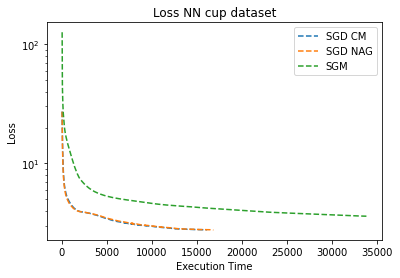

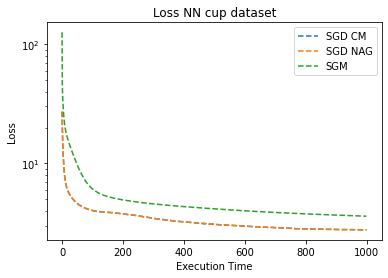

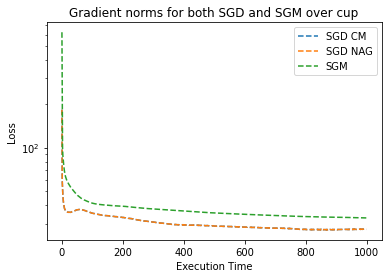

<Figure size 432x288 with 0 Axes>

In [13]:
report_plots(dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_SGM=net_SGM, score=score)